# Inheriting from Unit

### Abstract attributes and methods

![Unit UML Diagram](./Unit_UML.png "Unit UML Diagram")

**A Unit subclass has class attributes that dictate how an instance is initialized:**
    
* `_F_BM_default` : dict[str, float] Default bare module factors for each purchase cost item.

* `_units` : [dict] Units of measure for the `design_results` items.

* `_N_ins`=1 : [int] Expected number of input streams.
    
* `_N_outs`=2 : [int] Expected number of output streams.
    
* `_ins_size_is_fixed`=True : [bool] Whether the number of streams in ins is fixed.
    
* `_outs_size_is_fixed`=True : [bool] Whether the number of streams in outs is fixed.
    
* `_N_heat_utilities`=0 : [int] Number of heat utility objects in the `heat_utilities` tuple.

* `auxiliary_unit_names`=() : tuple[str] Name of attributes that are auxiliary units.

* `_graphics` : [biosteam Graphics] A Graphics object for diagram representation. Defaults to a box diagram.

* `_default_equipment_lifetime` : [int] or dict[str, int] Default lifetime of equipment. Defaults to lifetime of production venture.
    
* `line` : [str] Label for the unit operation in a diagram. Defaults to the class name.

**Abstract methods are used to setup stream conditions, run heat and mass balances, find design requirements, and cost the unit:**

* `_setup()` : Called before System convergece to initialize constant data and setup stream conditions.

* `_run()` : Called during System convergece to specify `outs` streams.

* `_design()` : Called after System convergence to find design requirements. 

* `_cost()` : Called after `_design` to find cost requirements.

**These abstract methods will rely on the following instance attributes:**

* `ins` : Ins[Stream] Input streams.

* `outs` : Outs[Stream] Output streams.

* `power_utility` : [PowerUtility] Can find electricity rate requirement.

* `heat_utilities` : tuple[HeatUtility] Can find cooling and heating requirements.

* `design_results` : [dict] All design requirements.

* `baseline_purchase_costs` : [dict] Itemized purchase costs (without accounting for design, pressure or material factors).

* `F_BM`: [dict] Bare-module factors.

* `F_D`: [dict] Design factors.

* `F_P`: [dict] Pressure factors.

* `F_M`: [dict] Material factors.

* `equipment_lifetime`: [dict] Lifetime of each equiment.

* `thermo` : [Thermo] The thermodynamic property package used by the unit.

### Subclass example

The following example depicts inheritance from Unit by creating a new Boiler class:

In [1]:
import biosteam as bst
from math import ceil

class Boiler(bst.Unit):
    """
    Create a Boiler object that partially boils the feed.
    
    Parameters
    ----------
    ins : stream
        Inlet fluid.
    outs : stream sequence
        * [0] vapor product
        * [1] liquid product
    V : float
        Molar vapor fraction.
    P : float
        Operating pressure [Pa].
    
    """
    # Note that the documentation does not include `ID` or `thermo` in the parameters.
    # This is OK, and most subclasses in BioSTEAM are documented this way too.
    # Documentation for all unit operations should include the inlet and outlet streams
    # listed by index. If there is only one stream in the inlets (or outlets), there is no
    # need to list out by index. The types for the `ins` and `outs` should be either
    # `stream sequence` for multiple streams, or `stream` for a single stream.
    # Any additional arguments to the unit should also be listed (e.g. V, and P).
    
    _N_ins = 1  
    _N_outs = 2
    _N_heat_utilities = 1
    _units = {'Area': 'm^2'}
    
    def __init__(self, ID='', ins=None, outs=(), thermo=None, *, V, P):
        bst.Unit.__init__(self, ID, ins, outs, thermo)
        # Initialize MultiStream object to perform vapor-liquid equilibrium later
        # NOTE: ID is None to not register it in the flowsheet
        self._multistream = bst.MultiStream(None, thermo=self.thermo)
        self.V = V #: Molar vapor fraction.
        self.P = P #: Operating pressure [Pa].
        
    def _setup(self):
        super()._setup()
        gas, liq = self.outs
        
        # Initialize top stream as a gas
        gas.phase = 'g'
        
        # Initialize bottom stream as a liquid
        liq.phase = 'l'
  
    def _run(self):
        feed = self.ins[0]
        gas, liq = self.outs
        
        # Perform vapor-liquid equilibrium
        ms = self._multistream
        ms.imol['l'] = feed.mol
        ms.vle(V=self.V, P=self.P)
        
        # Update output streams
        gas.mol[:] = ms.imol['g']
        liq.mol[:] = ms.imol['l']
        gas.T = liq.T = ms.T
        gas.P = liq.P = ms.P
        
        # Reset flow to prevent accumulation in multiple simulations
        ms.empty()
        
    def _design(self):
        # Calculate heat utility requirement (please read docs for HeatUtility objects)
        T_operation = self._multistream.T
        duty = self.H_out - self.H_in
        if duty < 0:
            raise RuntimeError(f'{repr(self)} is cooling.')
        hu = self.heat_utilities[0]
        hu(duty, T_operation)
        
        # Temperature of utility at entrance
        T_utility = hu.inlet_utility_stream.T
        
        # Temeperature gradient
        dT = T_utility - T_operation
        
        # Heat transfer coefficient kJ/(hr*m2*K)
        U = 8176.699 
        
        # Area requirement (m^2)
        A = duty/(U*dT)
        
        # Maximum area per unit
        A_max = 743.224
        
        # Number of units
        N = ceil(A/A_max)
        
        # Design requirements are stored here
        self.design_results['Area'] = A/N
        self.design_results['N'] = N
        
    def _cost(self):
        A = self.design_results['Area']
        N = self.design_results['N']
        
        # Long-tube vertical boiler cost correlation from 
        # "Product process and design". Warren et. al. (2016) Table 22.32, pg 592
        purchase_cost = N*bst.CE*3.086*A**0.55
        
        # Itemized purchase costs are stored here
        self.baseline_purchase_costs['Boilers'] = purchase_cost # Not accounting for material factor
        
        # Assume design, pressure, and material factors are 1.
        self.F_D['Boilers'] = self.F_P['Boilers'] = self.F_M['Boilers'] = 1.
        
        # Set bare-module factor for boilers
        self.F_BM['Boilers'] = 2.45
    

### Simulation test

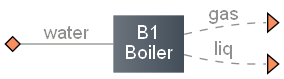

Boiler: B1
ins...
[0] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] liq
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


C:\Users\yrc2\Code\biosteam\biosteam\digraph\digraph.py:373: RuntimeWarning: a 'AttributeError' was raised when generating graphviz diagram, possibly due to graphviz installation issues
  warn(


In [2]:
import biosteam as bst
bst.settings.set_thermo(['Water'])
water = bst.Stream('water', Water=300)
B1 = Boiler('B1', ins=water, outs=('gas', 'liq'),
            V=0.5, P=101325)
B1.diagram()
B1.show()

In [3]:
B1.simulate()
B1.show()

Boiler: B1
ins...
[0] water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water  300
outs...
[0] gas
    phase: 'g', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150
[1] liq
    phase: 'l', T: 373.12 K, P: 101325 Pa
    flow (kmol/hr): Water  150


In [4]:
B1.results()

Boiler                         Units       B1
Low pressure steam  Duty       kJ/hr 8.23e+06
                    Flow     kmol/hr      212
                    Cost      USD/hr     50.4
Design              Area         m^2     24.5
                    N                       1
Purchase cost       Boilers      USD 1.02e+04
Total purchase cost              USD 1.02e+04
Utility cost                  USD/hr     50.4

### Graphviz attributes

All [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html) attributes for generating a diagram are stored in `_graphics` as a Graphics object. One Graphics object is generated for each Unit subclass:

In [5]:
graphics = Boiler._graphics
edge_in = graphics.edge_in
edge_out = graphics.edge_out
node = graphics.node

In [6]:
# Attributes correspond to each inlet stream respectively
# For example: Attributes for B1.ins[0] would correspond to edge_in[0]
edge_in 

[{'headport': 'c'}]

In [7]:
# Attributes correspond to each outlet stream respectively
# For example: Attributes for B1.outs[0] would correspond to edge_out[0]
edge_out

[{'tailport': 'c'}, {'tailport': 'c'}]

In [8]:
node # The node represents the actual unit

{'shape': 'box',
 'fillcolor': '#6b737c:#434e59',
 'style': 'filled',
 'gradientangle': '0',
 'width': '0.6',
 'height': '0.6',
 'orientation': '0.0',
 'color': 'none',
 'fontcolor': 'white',
 'peripheries': '1',
 'margin': 'default',
 'fontname': 'Arial',
 'name': 'B1\nBoiler'}

These attributes can be changed to the user's liking:

In [9]:
edge_out[0]['tailport'] = 'n'
edge_out[1]['tailport'] = 's'
node['width'] = '1'
node['height'] = '1.2'

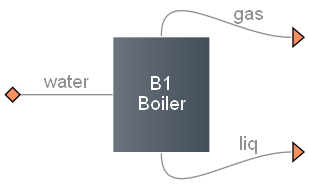

C:\Users\yrc2\Code\biosteam\biosteam\digraph\digraph.py:373: RuntimeWarning: a 'AttributeError' was raised when generating graphviz diagram, possibly due to graphviz installation issues
  warn(


In [10]:
B1.diagram()

It is also possible to dynamically adjust node and edge attributes by setting the `tailor_node_to_unit` attribute:

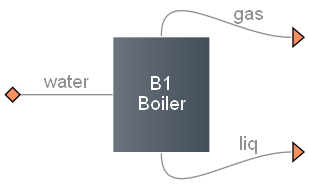

In [11]:
def tailor_node_to_unit(node, unit):
    feed = unit.ins[0]
    if not feed.F_mol:
        node['name'] += '\n-empty-'
graphics.tailor_node_to_unit = tailor_node_to_unit
B1.diagram()

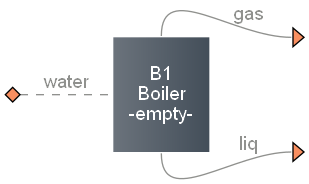

In [12]:
B1.ins[0].empty()
B1.diagram()

NOTE: The example implementation of the `tailor_node_to_unit` function is not suggested; best to keep diagrams simple.